In [116]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg
import os
import json

# load demand data
DATA_NAME = 'ndf50_mldat6e8_university'
path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data.json'.format(DATA_NAME)
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time to load data from /home/zciccwf/phd_project/projects/trafpy/trafpy/../data/benchmark_data/ndf50_mldat6e8_university_benchmark_data.json: 5.326070070266724 s


In [117]:
%autoreload

# organise into list of demand_data dicts
benchmarks = list(benchmark_data.keys())
demand_data_list = []
loads = []
for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)
            loads.append(load)
num_sets_of_demand_data = len(demand_data_list)
print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))

Number of sets of demand data: 10


/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.matshow(node_dist, cmap='YlOrBr')
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # HISTOGRAM
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retain

+----+--------+---------+-------+-------------+-------------+-------------+----------+------------+-------------+
|    | Name   |   Flows |   1st |        Last |    Duration |        Info |     Load |   Smallest |     Largest |
|----+--------+---------+-------+-------------+-------------+-------------+----------+------------+-------------|
|  0 | demand |   48000 |     0 | 6.23493e+08 | 6.23493e+08 | 7.41748e+08 |  1.18967 |          1 | 1.69803e+06 |
|  1 | demand |   96000 |     0 | 7.21285e+08 | 7.21285e+08 | 1.64144e+09 |  2.27572 |          1 | 2.0964e+06  |
|  2 | demand |  192000 |     0 | 1.19764e+09 | 1.19764e+09 | 3.42507e+09 |  2.85984 |          1 | 2.85338e+06 |
|  3 | demand |  192000 |     0 | 7.1112e+08  | 7.1112e+08  | 3.18293e+09 |  4.47593 |          1 | 2.48181e+06 |
|  4 | demand |  192000 |     0 | 6.82317e+08 | 6.82317e+08 | 3.66463e+09 |  5.37085 |          1 | 1.22478e+07 |
|  5 | demand |  384000 |     0 | 9.42242e+08 | 9.42242e+08 | 6.37983e+09 |  6.77091 |  

/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ylabel='CDF',
/home/zciccwf/phd_project/projects/trafpy/trafpy/generator/src/dists/plot_dists.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ylabel='CDF',


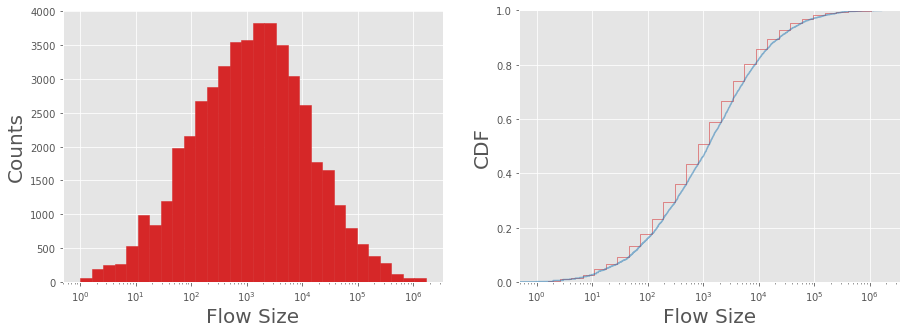

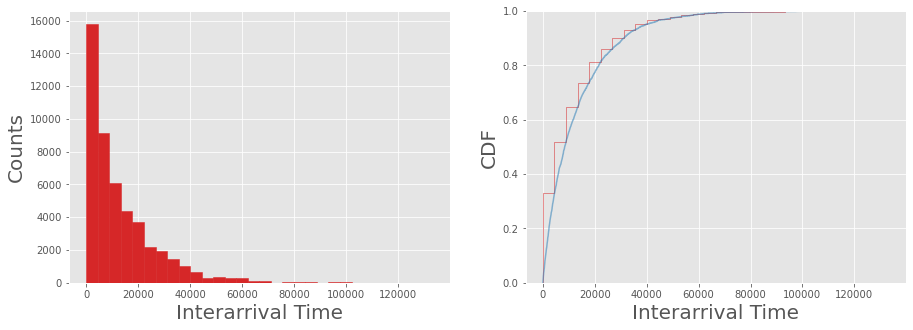

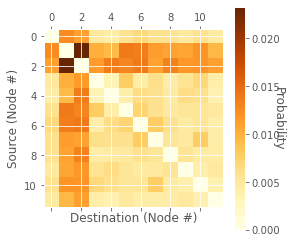

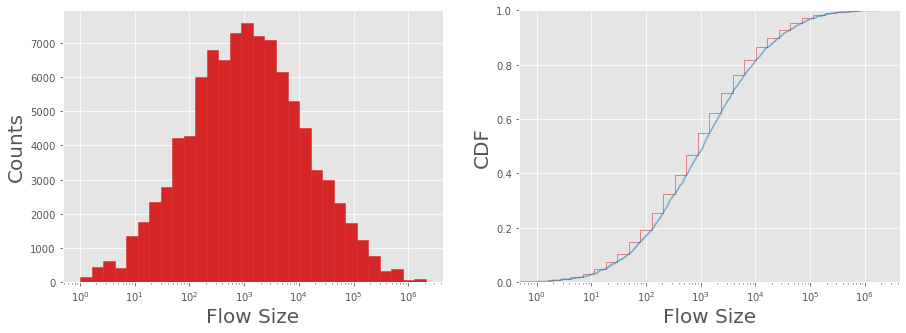

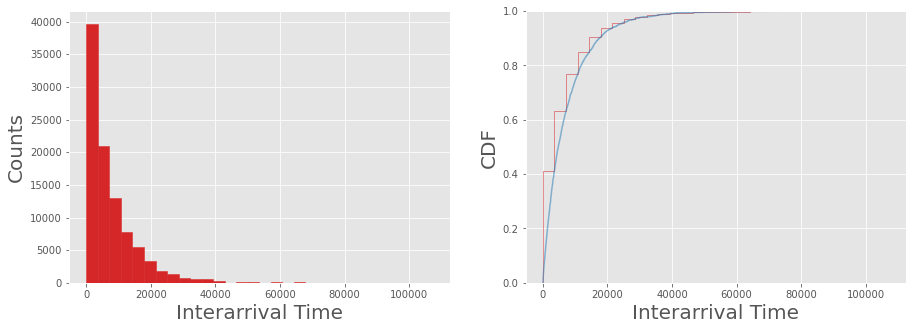

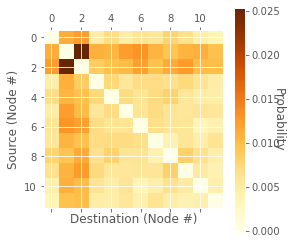

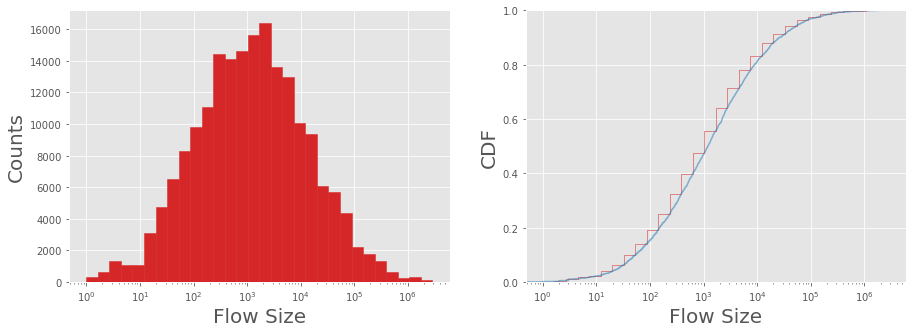

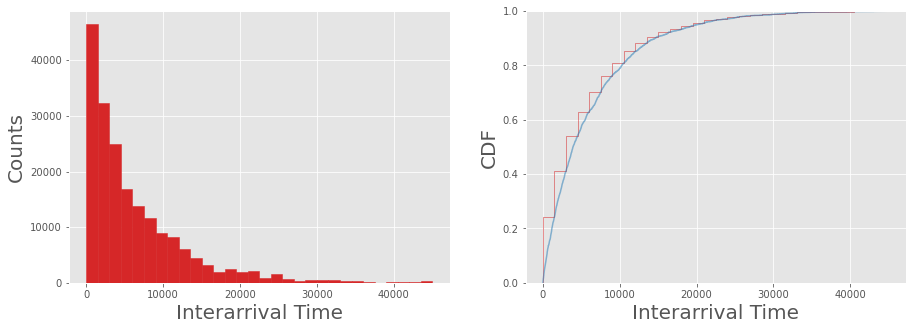

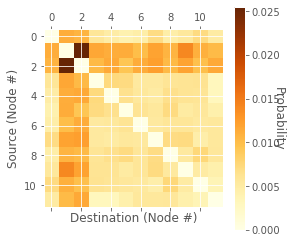

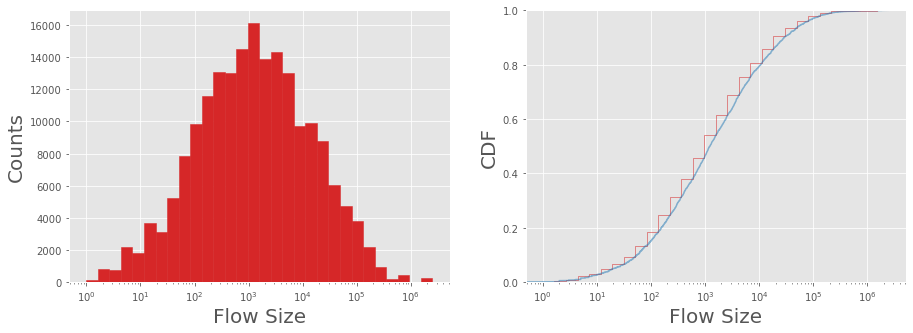

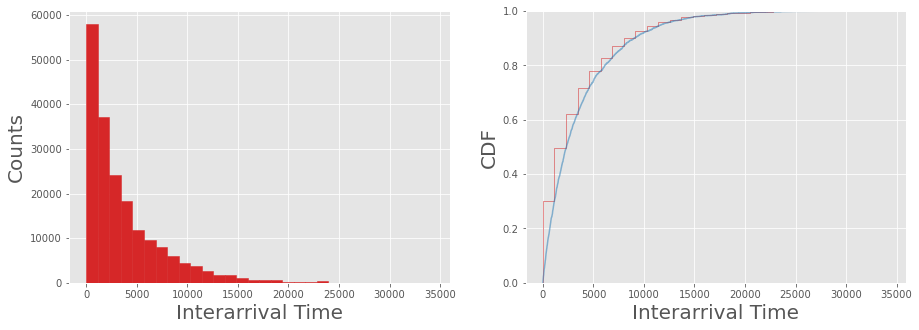

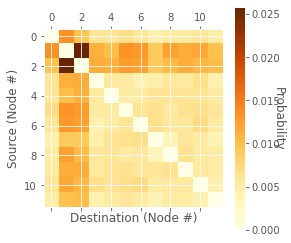

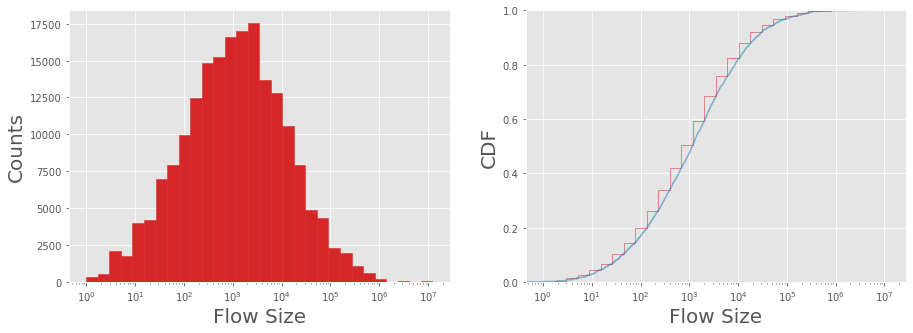

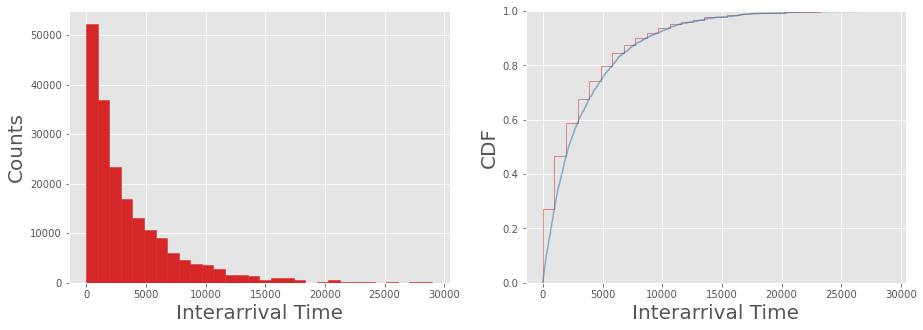

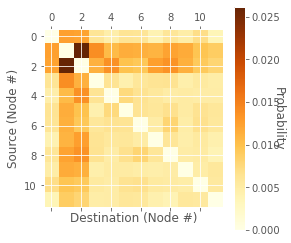

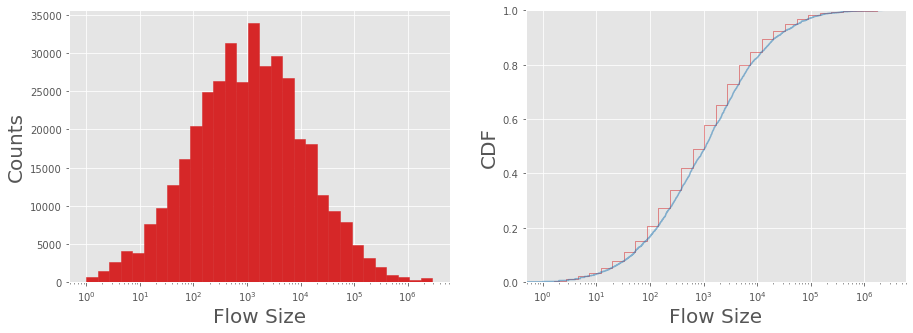

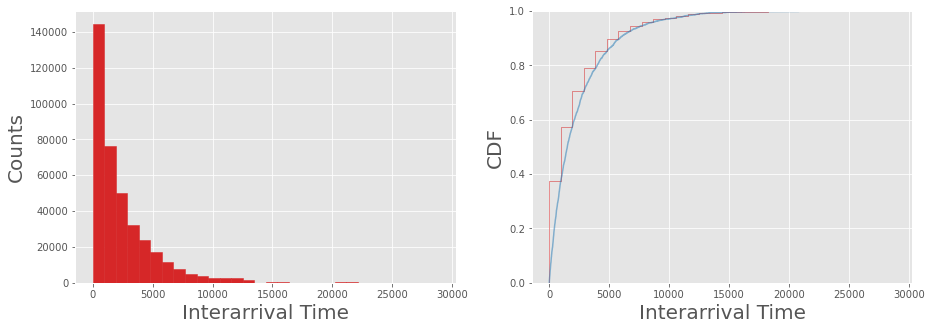

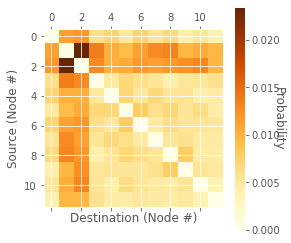

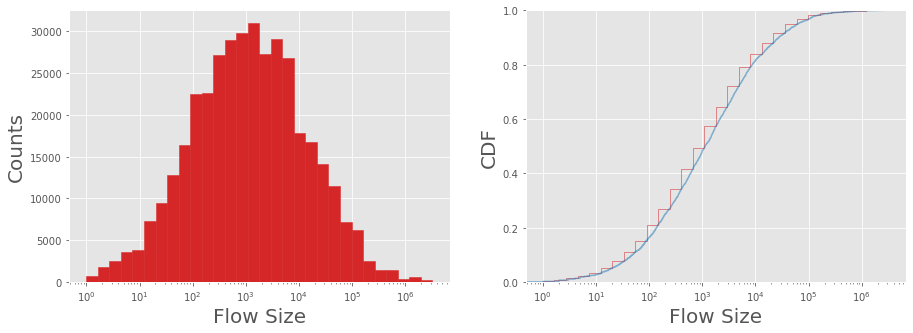

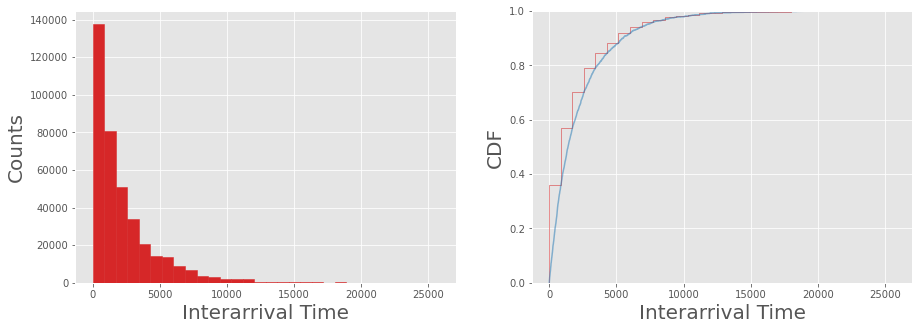

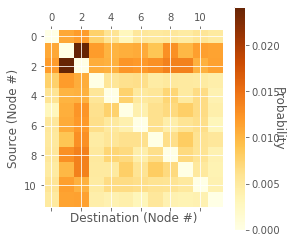

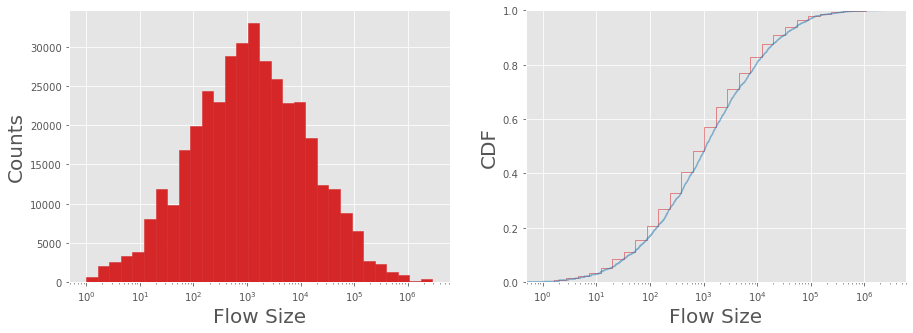

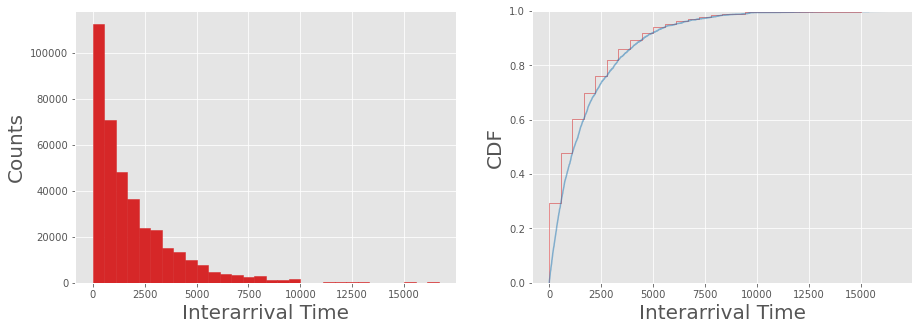

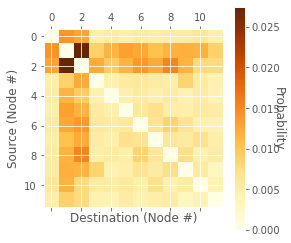

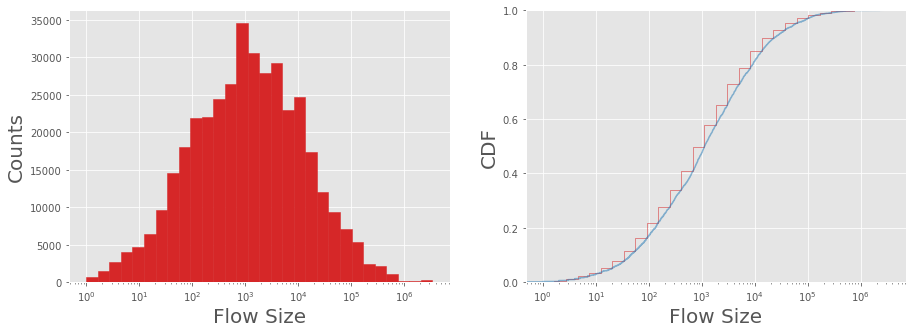

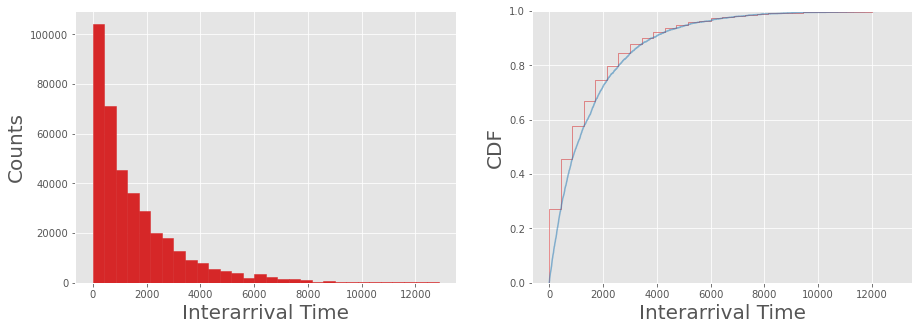

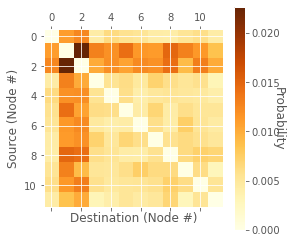

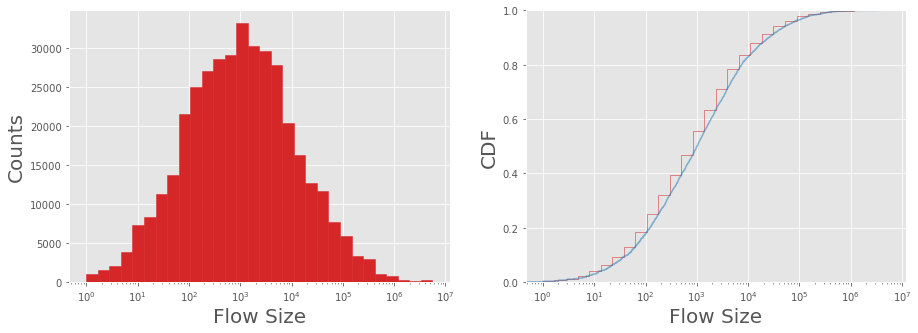

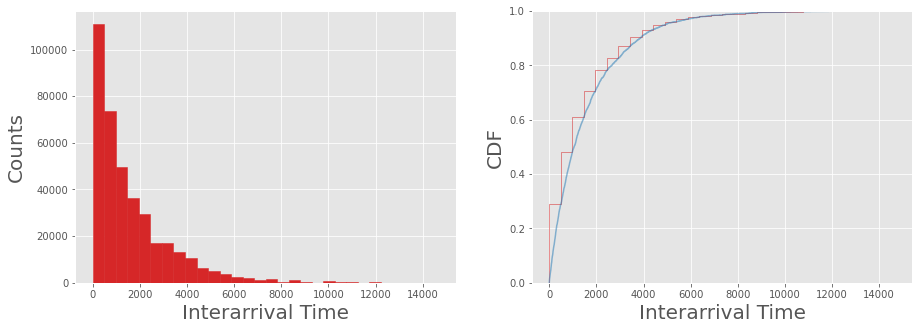

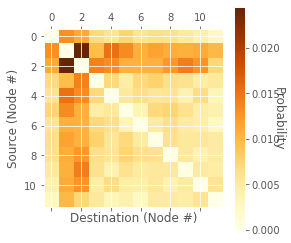

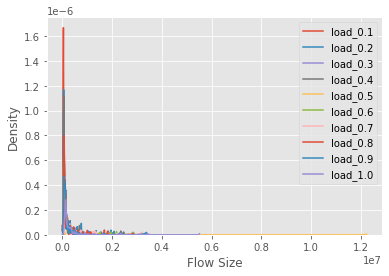

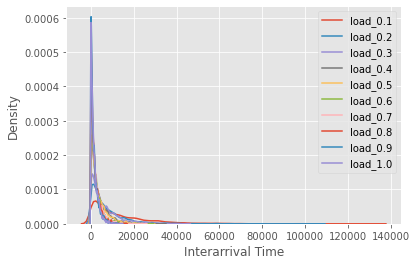

In [118]:
%autoreload
import matplotlib.pyplot as plt
from trafpy.manager import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# create demand objects and print analysis summary
demands = []
for demand_data, load in zip(demand_data_list, loads):
    demand = Demand(demand_data)
    demand.name = 'load_{}'.format(load) # name for multi-plot legend(s)
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=['server_{}'.format(i) for i in range(12)])
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

plotters = DemandsPlotter(*demands)
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)

In [119]:
%autoreload
print('Keys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
# print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

Keys of first demand data set:
dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])


In [120]:
%autoreload
for benchmark in benchmarks:
    print(benchmark_data[benchmark].keys())
    for load in list(benchmark_data[benchmark].keys()):
        for repeat in benchmark_data[benchmark][load]:
            print('benchmark: {} | load: {} | repeat: {}'.format(benchmark,load,repeat))

dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
benchmark: university | load: 0.1 | repeat: 0
benchmark: university | load: 0.2 | repeat: 0
benchmark: university | load: 0.3 | repeat: 0
benchmark: university | load: 0.4 | repeat: 0
benchmark: university | load: 0.5 | repeat: 0
benchmark: university | load: 0.6 | repeat: 0
benchmark: university | load: 0.7 | repeat: 0
benchmark: university | load: 0.8 | repeat: 0
benchmark: university | load: 0.9 | repeat: 0
benchmark: university | load: 1.0 | repeat: 0
